# Testing specificity

    Author: Thomas Cokelaer
    Jan 2018

Testing specificity (ratio of the number of true negatives to the number of negatives).
We use the data and strategy described in section 3.2 of "CNOGpro: detection and quantification 
of  CNVs in prokaryotic whole-genome sequencing data, bioinformatics 31(11), 2015 (Brynildsrud et al)"

Here, we will use the same reference: FN433596 (staphylococcus aureus)

Goal is to check that the specificity is low and sensitivity is high (by injection of CNVs).

# Requirements

- sequana version 0.6.3post1 was used
- art_illumina
- bioconvert (optional)

# Get the reference 

In [209]:
!sequana_coverage --download-reference FN433596

INFO    [sequana]:  Downloading reference FN433596 from ENA



# simulated data 

Simulation of data coverage 100X

```
-l: length of the reads
-f: coverage
-m: mean size of fragments
-s: standard deviation of fragment size
-ss: type of hiseq
```
This taks a few minutes to produce 

In [199]:
! art_illumina -sam -i FN433596.fa -p -l 100 -ss HS20 -f 20 -m 500 -s 40 -o paired_dat -f 100

=======================================ART======================================
                            ART_Illumina (2008-2015)                            
                            Q Version 2.3.7 (Mar 19, 2015)                      
                     Contact: Weichun Huang at whduke@gmail.com                 

                          Paired-end sequencing simulation

Total CPU time used: 51.6

The random seed for the run: 1515972964

Parameters used during run
	Read Length:	100
	Genome masking 'N' cutoff frequency: 	1 in 100
	Fold Coverage:            100X
	Mean Fragment Length:     500
	Standard Deviation:       40
	Profile Type:             Combined
	ID Tag:                   

Quality Profile(s)
	First Read:   HiSeq 2000 Length 100 R1 (built-in profile) 
	First Read:   HiSeq 2000 Length 100 R2 (built-in profile) 
Output files

  FASTQ Sequence Files:
	 the 1st reads: paired_dat1.fq
	 the 2nd reads: paired_dat2.fq

  ALN Alignment Files:
	 the 1st reads: paired_dat1.al

# mapping

In [203]:
# no need for the *aln and *sam, let us remove them to save space
!rm -f paired*.aln paired_dat.sam
!sequana_mapping --reference FN433596.fa --file1 paired_dat1.fq --file2 paired_dat2.fq  1>out 2>err


This uses bwa and samtools behind the scene. Then, we will convert the resulting BAM file (FN433596.fasta.sorted.bam) into a BED file once for all. To do so, we use bioconvert (bioconvert.readthedocs.io) that uses bedtools behind the scene:


You can clean you directory. We just need the BED file:

```
rm FN433596.fa.sorted.bam
```

In [218]:
!bioconvert FN433596.fa.sorted.bam simulated.bed -f
# or use e.g. bedtools:
# bedtools genomecov -d -ibam input.bam > output.bed

WARNING [bioconvert.core.converter]:  output file exists already
WARNING [bioconvert.core.converter]:  output file will be overwritten
INFO    [bioconvert.core.converter]:  Input: .bam
INFO    [bioconvert.core.converter]:  Output: .bed
INFO    [bioconvert.core.converter]:  Using BAM2BED class
INFO    [bioconvert]:  Converting from .bam to .bed
INFO    [bioconvert.core.base]:  Executing samtools method
INFO    [bioconvert.core.base]:  BAM2BED> 
INFO    [bioconvert.core.base]:  CMD: samtools depth -aa FN433596.fa.sorted.bam > simulated.bed
INFO    [bioconvert.core.shell]:  samtools depth -aa FN433596.fa.sorted.bam > simulated.bed
INFO    [bioconvert.core.base]:  Took 16.61863660812378 seconds 


# sequana_coverage

In [208]:
!sequana_coverage --input simulated.bed --reference FN433596.fa -w 40001 -o --logging-level WARNING
!cp report/*/*/rois.csv rois_noise_40001.csv

INFO    [sequana]:  Reading simulated.bed. This may take time depending on your input file
INFO    [sequana]:  Computing GC content
WARNING [sequana]:  There is only one chromosome. Selected automatically.

Genome length: 3043210
Sequencing depth (DOC):    99.99 
Sequencing depth (median):   100.00 
Breadth of coverage (BOC) (percent): 100.00 
Genome coverage standard deviation :    10.11 
Genome coverage coefficient variation :     0.10 
INFO    [sequana]:  Computing running median (w=40001)
Number of mixture model 2 
Computing zscore
WARNING [sequana]:  Warning: k=2 but note that |mu0-mu1| < sigma0. k=1 could be a better choice
Number of ROIs found: 24
INFO    [sequana]:  Computing centralness
Low threshold: -4
High threshold: 4
double-low threshold: -2.0
double-high threshold: 2.0
sigma and mu of the central distribution: mu=1.008, sigma=0.103
Evenness:    0.960
Centralness (3 sigma): 0.996000
Centralness (4 sigma): 0.999600



INFO    [sequana]:  Creating report in report. Please w

Several ROIs are found. There is none in CNOGpro. 
The ROIs have zscore between 4 and 5. 

In [210]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/cokelaer/miniconda3/envs/py3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'size']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [212]:
#Here is a convenient function to plot the ROIs in terms of sizes and max zscore

def plot_results(file_roi):
    import pandas as pd
    roi = pd.read_csv(file_roi) #"rois_cnv_deletion.csv")
    roi = roi.query("start>100 and end<3043210")
    plot(roi["size"], roi["max_zscore"], "o")
    for this in [3,4,-3,-4]:
        axhline(this)
    print(len(roi))
    return roi

22


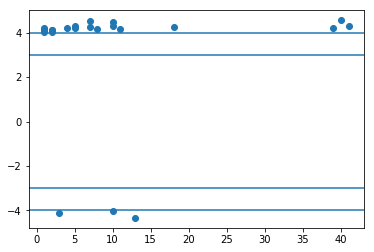

In [213]:
roi = plot_results("rois_noise_40001.csv")

# Decrease threshold to 3

In [219]:
!sequana_coverage --input simulated.bed --reference FN433596.fa -w 40001 -o -H 3 -L -3 --logging-level WARNING 
!cp report/*/*/rois.csv rois_noise_40001_threshold3.csv

WARNING [sequana]:  There is only one chromosome. Selected automatically.

Genome length: 3043210
Sequencing depth (DOC):    99.99 
Sequencing depth (median):   100.00 
Breadth of coverage (BOC) (percent): 100.00 
Genome coverage standard deviation :    10.11 
Genome coverage coefficient variation :     0.10 
Number of mixture model 2 
Computing zscore
WARNING [sequana]:  Warning: k=2 but note that |mu0-mu1| < sigma0. k=1 could be a better choice
Number of ROIs found: 493
Low threshold: -3.0
High threshold: 3.0
double-low threshold: -1.5
double-high threshold: 1.5
sigma and mu of the central distribution: mu=1.008, sigma=0.103
Evenness:    0.960
Centralness (3 sigma): 0.996000
Centralness (4 sigma): 0.999600



Computing 2D histogram. Please wait
/home/cokelaer/miniconda3/envs/py3/lib/python3.5/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'color'
  s)


491


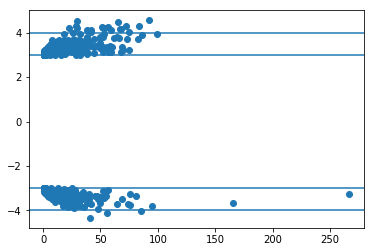

In [220]:
roi = plot_results("rois_noise_40001_threshold3.csv")

# Checking CNV detection

## Mix of deletion, duplication 

In [221]:
import random

def create_deletion():
    df = pd.read_csv("simulated.bed", sep="\t", header=None)
    positions = []
    sizes = []
    for i in range(80):
        # the + and -4000 shift are there to guarantee the next
        # CNV does not overlap with the previous one since
        # CNV length can be as much as 8000
        pos = random.randint(37000*i+4000, 37000*(i+1)-4000)
        size = random.randint(1,8) * 1000
        positions.append(pos)    
        #size = 2000
        df.loc[pos:pos+size,2] = 0 #deletion
        sizes.append(size)
    df.to_csv("cnv_deletion.bed", sep="\t", header=None, index=None)
    return positions, sizes


def create_duplicated():
    df = pd.read_csv("simulated.bed", sep="\t", header=None)
    positions = []
    sizes = []
    for i in range(80):
        pos = random.randint(37000*i+4000, 37000*(i+1)-4000)
        size = random.randint(1,8) * 1000
        positions.append(pos)    
        
        df.loc[pos:pos+size,2] += 100 #duplicated
        sizes.append(size)
    df.to_csv("cnv_duplicated.bed", sep="\t", header=None, index=None)
    return positions, sizes



def create_cnvs_mixed():
    df = pd.read_csv("simulated.bed", sep="\t", header=None)
    # we will place 10% of CNV of size from 1000 to 8000
    import random
    positions = []
    sizes = []
    for i in range(80):
        pos = random.randint(37000*i+4000, 37000*(i+1)-4000)
        size = random.randint(1,8) * 1000
        positions.append(pos)
    
        status = random.randint(0,1)
    
        if status == 0:
            df.loc[pos:pos+size,2] -= 50 
        elif status == 1:
            df.loc[pos:pos+size,2] += 50 
        
        sizes.append(size)
    df.to_csv("cnv_mixed.bed", sep="\t", header=None, index=None)
    return positions, sizes



In [222]:
def check_found(positions, sizes, roi, precision=200, min_size=200):
    """A simple function to check given the position and size that
    the injected CNVs are detected in the ROIs
    
    We check that the starting or ending position of at least one
    ROI coincide with one ROI and that this ROI has at least a length of 200.
    
    Indeed, injections are at least 1000 bases and noise are generally below 100 bases
    as shown above.
    
    
    """
    found = [False] * len(positions)
    i = 0
    for position,size in zip(positions, sizes):

        for this in roi.iterrows():
            this = this[1]        
            if (abs(this.start-position)<precision or abs(this.end-position-size)<precision )and this['size'] > min_size:
                #print(this.start, this.end, position, size)
                found[i] = True
                continue
        
        if found[i] is False:
            print("position not found {} size={}".format(position, size))
        i+=1
    print("Found {}".format(sum(found)))
    return 


# Deleted regions are all detected

In [223]:
# call this only once !!!!
positions_deletion, sizes_deletion = create_deletion()
!sequana_coverage --input cnv_deletion.bed -o -w 40001 --logging-level WARNING 
!cp report/*/*/rois.csv rois_cnv_deleted.csv

WARNING [sequana]:  There is only one chromosome. Selected automatically.

Genome length: 3043210
Sequencing depth (DOC):    89.36 
Sequencing depth (median):    98.00 
Breadth of coverage (BOC) (percent): 89.35 
Genome coverage standard deviation :    32.31 
Genome coverage coefficient variation :     0.36 
Number of mixture model 2 
Computing zscore
WARNING [sequana]:  Warning: k=2 but note that |mu0-mu1| < sigma0. k=1 could be a better choice
Number of ROIs found: 104
Low threshold: -4
High threshold: 4
double-low threshold: -2.0
double-high threshold: 2.0
sigma and mu of the central distribution: mu=1.025, sigma=0.107
Evenness:    0.887
Centralness (3 sigma): 0.890000
Centralness (4 sigma): 0.893100





102


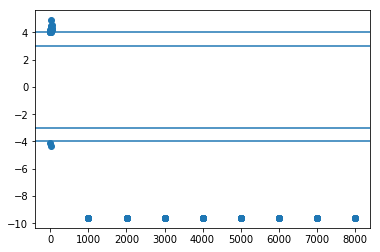

In [224]:
rois_deletion = plot_results("rois_cnv_deleted.csv")

In [225]:
# as precise as 2 base position. Here we put 20 we 2 should give pretty gigh detection
# rate already. 
check_found(positions_deletion, sizes_deletion, rois_deletion, precision=20)

Found 80


# duplicated regions

In [226]:
# call this only once !!!!
positions_duplicated, sizes_duplicated = create_duplicated()
!sequana_coverage --input cnv_duplicated.bed -o -w 40001 --logging-level WARNING 
!cp report/*/*/rois.csv rois_cnv_duplicated.csv

WARNING [sequana]:  There is only one chromosome. Selected automatically.

Genome length: 3043210
Sequencing depth (DOC):   111.92 
Sequencing depth (median):   102.00 
Breadth of coverage (BOC) (percent): 100.00 
Genome coverage standard deviation :    33.92 
Genome coverage coefficient variation :     0.30 
Number of mixture model 2 
Computing zscore
Number of ROIs found: 104
Low threshold: -4
High threshold: 4
double-low threshold: -2.0
double-high threshold: 2.0
sigma and mu of the central distribution: mu=0.984, sigma=0.1
Evenness:    0.901
Centralness (3 sigma): 0.877000
Centralness (4 sigma): 0.880300





102


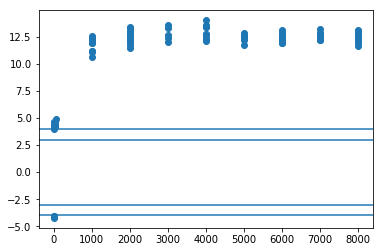

In [227]:
rois_duplicated = plot_results("rois_cnv_duplicated.csv")

In [228]:
check_found(positions_duplicated, sizes_duplicated, rois_duplicated, precision=10)

Found 80


# Mixes

In [190]:
positions_mix, sizes_mix = create_cnvs_mixed()
!sequana_coverage --input cnv_mixed.bed -o -w 40001 --logging-level WARNING 
!cp report/*/*/rois.csv rois_cnv_mixed.csv

WARNING [sequana]:  There is only one chromosome. Selected automatically.

Genome length: 3043210
Sequencing depth (DOC):   100.20 
Sequencing depth (median):   100.00 
Breadth of coverage (BOC) (percent): 100.00 
Genome coverage standard deviation :    19.74 
Genome coverage coefficient variation :     0.20 
Number of mixture model 2 
Computing zscore
WARNING [sequana]:  Warning: k=2 but note that |mu0-mu1| < sigma0. k=1 could be a better choice
Number of ROIs found: 254
Low threshold: -4
High threshold: 4
double-low threshold: -2.0
double-high threshold: 2.0
sigma and mu of the central distribution: mu=0.999, sigma=0.089
Evenness:    0.937
Centralness (3 sigma): 0.872000
Centralness (4 sigma): 0.884000





252


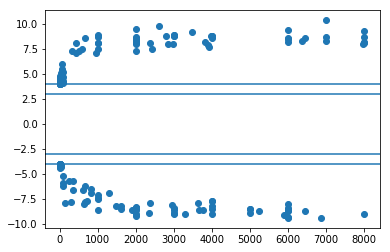

In [191]:
rois_mixed = plot_results("rois_cnv_mixed.csv")

In [195]:
check_found(positions_mix, sizes_mix, rois_mixed,precision=20)

Found 80


# Conclusions

- pure simulated: the events that passes the threshold are limited to a few tens of detection with zscore close to the threshold of 4 and with sizes below 100 bases. 
- Simulated CNVs:
    - the 80 deletions are all detected with the correct position and sizes
    - the 80 duplications are all detected with the correct position and sizes
    - the mix of 80 detection with coverage at 50 and 150 are all detected. Note, however, that some CNVs detections are split in several events. For instance instead of a 3000 length region, two regions of about 1000 and 2000 may be detected separately.